In [2]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.stats import wilcoxon 

# I. MLS Detection: Defining Essential Functions

Hey Ben. The functions defined below are all sub-functions of a master "detect_MLS()" function that will take a dataframe as input and return an additional column called 'model_midline_shift.' 

It is, admittedly, a bit of a complex pipeline that takes advantage of regular expressions pretty extensively and implements a hierarchy of semantic rules. I can't deny it could probably be improved, but overall it is yielding pretty good results on my data. The documentation and comments might be a little sketchy in this early version, so I do apologize for that too. I can elborate more, especially if you run into issues using it. 

I don't think there is specific preprocessing that needs to be done for this to work. However, you may find much better results if you use a "clean_and_featurize" function, which I have included here, for which you will also need an additional spreadsheet called 'wordgroups.xlsx'. I have included that file in this repo alongside this Jupyter Notebook. This function eases tokenization of the report, and seems to really boost featurization. You will also notice some additional preprocessing where I remove 'confounding' numbers, like spinal levels, hemorrhage dimension, etc. 

Once you finish running the "detect_MLS" function, I also have included a "compute_MLS_stats()" function which returns a list of mean absolute error (in mm),accuracy,sensitivity,specificity,NPV, and NPV. All results returned in the 'model_mildine_shift' column will be in millimeters, and I have taken care of the centimeter/millimeter conversions within the code. Hope this works for you!

## I.I: Sub-functions within the master "detect_MLS()" function.

In [3]:
def find_column_sum(x1,x2,x3,x4,x5):
    counter=0
    for i in [x1,x2,x3,x4,x5]:
        if i!=0:
            counter+=1
    return counter

def convert_all_to_millimeters(df):
    #now further convert down to midline shift in millimeters:
    float_pattern =re.compile(r'\d\.?\d?|\d\.?\d?')
    mls_millimeters = []
    df['model_midline_shift'] = [str(x) for x in df.model_midline_shift]
    for entry in df.model_midline_shift:
        if 'cm' in entry: #if cm is in the entry, a number probably is too...right?
            calculated = 10*float(float_pattern.findall(entry)[0])
            mls_millimeters.append(calculated)
        elif len(float_pattern.findall(entry))>0:
            calculated = float(float_pattern.findall(entry)[0])
            mls_millimeters.append(calculated)
        else:
            mls_millimeters.append(np.nan)
    
    
    df['model_midline_shift'] = mls_millimeters
    
    return df


def clean_and_featurize(df,wordgroups):
    
    labeled = df
    #labeled = labeled[['Report_ID','Report_Text','MLS_mm']] #this is not needed
    
    #rename columns to relevant
    #labeled = labeled.rename(columns={"Report_ID": "Report_Number"})
    
    # Keep only those with IMPRESSIONS
    labeled = labeled.iloc[[x for x in range(labeled.shape[0]) if 'IMPRESSION:' in labeled.Report_Text.iloc[x]]]
    
    # replace whitespace with space ***************************
    labeled['Report_Text_clean'] = labeled['Report_Text'].apply(lambda text: ' '.join(text.split()))
    
    #REMOVE HEADER:
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: re.split('-'*78, text, 1)[-1])
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: re.split('HISTORY:', text, 1)[-1])
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: re.split('REPORT ', text, 1)[-1])
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: re.split('REPORT:', text, 1)[-1])
    
    #REMOVE FOOTER:
    # Remove footer parts
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: 
                                                       re.split('electronically signed by:', text, flags=re.IGNORECASE)[0])
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: 
                                                       ''.join(re.split('i, the teaching physician, have reviewed the images and agree with the report as written', text, flags=re.IGNORECASE)))
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: 
                                                       re.split('radiologists: signatures:', text, flags=re.IGNORECASE)[0])
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: 
                                                       re.split('providers: signatures:', text, flags=re.IGNORECASE)[0])
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: 
                                                       re.split('findings were discussed on', text, flags=re.IGNORECASE)[0])
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: 
                                                       re.split('this report was electronically signed by', text, flags=re.IGNORECASE)[0])

    # Remove reference texts =====
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: ''.join([x for i,x in enumerate(text.split('='*34)) if i != 1]))
    
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: text.lower())
    
    
    # Replace ngrams in Report_Text & IMPRESSION with their units
    for group in wordgroups:
        labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: text.replace(group, ''.join(group.split())))

    labeled = labeled.drop_duplicates(subset=['Report_ID'])
    labeled = labeled.reset_index(drop=True)
    
    return labeled


#1a
def zero_mls_detector(df):
    """Crude check if midline shift is zero"""
    reports = df['Report_Text_clean']
    num_pattern = re.compile(r'\d')
    mls_shifts = []
    
    for report in reports: 
        #split by sentences
        split_list = re.split('\.',report)
        #only take sentences w/ the the follow keywords in them
        shift_list = [x for x in split_list if 'shift' in x]
        deviation_list= [x for x in split_list if 'deviation' in x]
        herniation_list= [x for x in split_list if 'herniation' in x]
        now_list= [x for x in split_list if 'now' in x]
        
        
        
        final_list = shift_list+deviation_list+herniation_list+now_list

        tracker = 0
        #for all sentences with 'shift' in them
        for sentence in final_list:
            if num_pattern.search(sentence): #if you get a numerical match, update tracker
                tracker +=1
        if tracker >0:
            mls_shifts.append(-1)
        else:
            mls_shifts.append(0)
            
    df['model_midline_shift']=mls_shifts
        
    return df

#1b
def no_midlineshift(df):
    reports = df['Report_Text_clean']
    mls_shifts = []
    
    for report in reports:
        if np.logical_or('no midlineshift' in report,'without midlineshift' in report):
            mls_shifts.append(0)

        else:

            mls_shifts.append(-1)
    

    df['model_midline_shift']=mls_shifts
    
    return df

#1c
def no_keywords(df):
    reports = df['Report_Text_clean']
    mls_shifts = []
    keywords = ['shift','deviation','herniation']
    for report in reports:
        tracker = 0
        for word in keywords:
            if word in report:
                tracker+=1
        
        if tracker==0: #if you don't identify any of the keywords...
            mls_shifts.append(0)
        else:
            mls_shifts.append(-1)

    df['model_midline_shift']=mls_shifts
    
    return df

def to_from(df): #done
    """from ... to"""
    list_of_midlineshifts = []
    
    #to/from...from/to
    pattern = re.compile(r'shift.+from.+\d.+to.+mm|shift.+from.+\d.+to.+cm|shift.+to.+\d.+from.+mm|shift.+to.+\d.+from.+cm')
    to_pattern =re.compile(r'to\s\d\.?\d?\smm|to\s\d\.?\d?\scm')
    num_pattern = re.compile(r'\d\.?\d?\smm|\d\.?\d?\scm')
    
    for report in df['Report_Text_clean']:
        match_1 = pattern.findall(report)
        
        if len(match_1)>0: #if you return at least SOMETHING from this match...     
            initial_match = match_1[0]
            
            if len(to_pattern.findall(initial_match))>0: #if you find a number...
                num_to=to_pattern.findall(initial_match)[0] #'to ...cm/mm'
                
                list_of_midlineshifts.append(num_pattern.findall(num_to)[0]) #to comes after from
            else:
                list_of_midlineshifts.append(-1) #if you don't match on 
        else:
            list_of_midlineshifts.append(-1)
    
    df['model_midline_shift']=list_of_midlineshifts
    return df

def now_measuring(df):
    list_of_midlineshifts=[]
    
    #non-greedy matching on 'shift...now...mm/cm'
    full_phrase_pattern=re.compile('shift.+now.+?mm|shift.+now.+?cm|deviation.+now.+?mm|deviation.+now.+?cm|herniation.+now.+?mm|herniation.+now.+?cm')
    
    #number matching
    num_pattern =re.compile(r'\d{,2}\.?\d?\smm|\d{,2}\.?\d?\scm|\d{,2}\.?\d?mm|\d{,2}\.?\d?cm')
    
    
    for report in df['Report_Text_clean']:
        match_1 = full_phrase_pattern.search(report)
        if match_1: #if you get a match back
            to_match=match_1[0] #get out the resultant string from the search object
            
            match_2=num_pattern.search(to_match) #try to get out a number from your initial match
            
            if match_2:
                list_of_midlineshifts.append(match_2[0])
        
            else:
                list_of_midlineshifts.append(-1) #if you don't get a number, append -1
        
        else:
            list_of_midlineshifts.append(-1)
        

    df['model_midline_shift']=list_of_midlineshifts
            
    return df

def shift_1(df): #done
    """Midline shift ..... cm/mm"""
    list_of_midlineshifts = []
    pattern = re.compile(r'shift.+\d\smm|shift.+\d\scm|herniation.+\d\smm|herniation.+\d\scm|deviation.+\d\smm|deviation.+\d\scm')
    num_pattern =re.compile(r'\d\.?\d?\smm|\d\.?\d?\scm|\d\smm|\d\scm')
    
    for report in df['Report_Text_clean']:
        match_1 = pattern.findall(report)
        
        if match_1:   #if this match exists 
            initial_match = match_1[0] #retrieve the first string from the match

            list_of_midlineshifts.append(num_pattern.findall(initial_match)[0]) #retrieve the number + mm/cm
        else:
            list_of_midlineshifts.append(-1) #append a dummy value if no matches found
    
    df['model_midline_shift']=list_of_midlineshifts #return dataframe w/ model_midline_shift esimated
    return df


def shift_2(df): #To-Do!
    """...cm/mm ....midline shift"""
    list_of_midlineshifts = []
    pattern = re.compile(r'\d\.?\d?\smm.+?shift|\d\.?\d?\scm.+?shift|\d\.?\d?\smm.+?herniation|\d\.?\d?\scm.+?herniation|\d\.?\d?\smm.+?deviation|\d\.?\d?\scm.+?deviation')
    num_pattern =re.compile(r'\d\.?\d?\smm|\d\.?\d?\scm|\d\smm|\d\scm')
    for report in df['Report_Text_clean']:
        match_1 = pattern.findall(report)
        
        if match_1:    
            initial_match = match_1[0]

            list_of_midlineshifts.append(num_pattern.findall(initial_match)[0])
        else:
            list_of_midlineshifts.append(-1)
    
    df['model_midline_shift']=list_of_midlineshifts
    return df

def nonzero_rule_system(df):
    
    #df=df[['Report_Text_clean','MLS_mm']]
    df['model_midline_shift']=np.zeros(len(df))

    #now add in rules:
    df['no_mls']=np.zeros(len(df))
    df['to_from']=np.zeros(len(df))
    df['now_measuring']=np.zeros(len(df))
    df['shift_1']=np.zeros(len(df))
    df['shift_2']=np.zeros(len(df))
    df['rules_satisfied']=np.zeros(len(df))
    df['shift_2']=np.zeros(len(df))


    #Sub floats for "French numerals"
    modded_reports = [re.sub(r'(\d)\.(\d)', r'\g<1>,\g<2>',report) for report in df['Report_Text_clean']]
    df['Report_Text_clean']=modded_reports

    #rules
    no_mls_re = re.compile(r'no midlineshift|no midline shift')
    shift1_pattern = re.compile(r'shift.+\d\smm|shift.+\d\scm|herniation.+\d\smm|herniation.+\d\scm|deviation.+\d\smm|deviation.+\d\scm')
    shift2_pattern = re.compile(r'\d,?\d?\smm.+?shift|\d,?\d?\scm.+?shift|\d,?\d?\smm.+?herniation|\d,?\d?\scm.+?herniation|\d,?\d?\smm.+?deviation|\d,?\d?\scm.+?deviation')
    now_measuring=re.compile('shift.+now.+?mm|shift.+now.+?cm|deviation.+now.+?mm|deviation.+now.+?cm|herniation.+now.+?mm|herniation.+now.+?cm')

    to_from = re.compile(r'shift.+from.+\d.+to.+mm|shift.+from.+\d.+to.+cm|shift.+to.+\d.+from.+mm|shift.+to.+\d.+from.+cm')
    to_ =re.compile(r'to.+\d\.?\d?\smm|to.+\d\.?\d?\scm')


    no_mls=[]

    #no MLS
    for i,row in df.iterrows():

        doc = []
        for sentence in row['Report_Text_clean'].split('.'):



            if len(no_mls_re.findall(sentence))>0:
                doc.append(no_mls_re.findall(sentence)[0])


            else:
                pass

        if len(doc)>0:
            no_mls.append(doc[0])
        else:
            no_mls.append(0)


    #         else:
    #             row['no_mls']=0
    shift_1=[]

    #shift 1            
    for i,row in df.iterrows():
        doc=[]

        for sentence in row['Report_Text_clean'].split('.'):

            if len(shift1_pattern.findall(sentence))>0:
                doc.append(shift1_pattern.findall(sentence)[0])
            else:
                pass

        if len(doc)>0:
            shift_1.append(doc[0])
        else:
            shift_1.append(0)

    shift_2=[]

    #shift 2:
    for i,row in df.iterrows():
        doc=[]

        for sentence in row['Report_Text_clean'].split('.'):

            if len(shift2_pattern.findall(sentence))>0:
                doc.append(shift2_pattern.findall(sentence)[0])
            else:
                pass

        if len(doc)>0:
            shift_2.append(doc[0])
        else:
            shift_2.append(0)


    now_measure=[]
    #now measuring:
    for i,row in df.iterrows():
        doc=[]

        for sentence in row['Report_Text_clean'].split('.'):

            if len(now_measuring.findall(sentence))>0:
                doc.append(now_measuring.findall(sentence)[0])
            else:
                pass

        if len(doc)>0:
            now_measure.append(doc[0])
        else:
            now_measure.append(0)

    to_fro=[]
    #to-from:
    for i,row in df.iterrows():
        doc=[]

        for sentence in row['Report_Text_clean'].split('.'):

            if len(to_from.findall(sentence))>0:
                match=to_from.findall(sentence)[0]
                doc.append(match)

    #             if len(to_.findall(match))>0:
    #                 doc.append(to_.findall(match)[0])
            else:
                pass

        if len(doc)>0:
            to_fro.append(doc[0])
        else:
            to_fro.append(0)


    df['no_mls']=no_mls
    df['to_from']=to_fro
    df['now_measuring']=now_measure
    df['shift_1']=shift_1
    df['shift_2']=shift_2


    df['rules_satisfied']=df.apply(lambda x: find_column_sum(x['no_mls'],x['to_from'],
                                                                  x['now_measuring'],x['shift_1'],x['shift_2']),axis=1)
    #must still account for places where no rules were satisfied
    df_zero=df[df['rules_satisfied']==0]
    df_zero['model_midline_shift']=len(df_zero)*['0']
    
    df=df[df['rules_satisfied']!=0]

    only_one_rule = df[df['rules_satisfied']==1]
    multiple_rules = df[df['rules_satisfied']>1]

    num_pattern = re.compile(r'\d\.?\d?\s?mm|\d\.?\d?\s?cm|\d\,?\d?\s?mm|\d\,?\d?\s?cm')

    midline_shifts=[]

    #hello
    for i,row in only_one_rule.iterrows():

        if row['no_mls']!=0:

            midline_shifts.append('0 mm')

        elif row['to_from']!=0:
            try:

                midline_shifts.append(num_pattern.findall(row['to_from'])[0])
            except:
                midline_shifts.append('0.0')
            
   

        #elif row['now_measuring']!=0:

        elif row['now_measuring']!=0:
            try:
#         elif len(num_pattern.findall(row['now_measuring'])[0])>0:
                midline_shifts.append(num_pattern.findall(row['now_measuring'])[0])
            except:
                midline_shifts.append('0.0')

        elif row['shift_1']!=0:
            try:

                midline_shifts.append(num_pattern.findall(row['shift_1'])[0])
            except:
                midline_shifts.append('0.0')
            
        elif row['shift_2']!=0:
            try:
                midline_shifts.append(num_pattern.findall(row['shift_2'])[0])
            except:
                midline_shifts.append('0.0')

    only_one_rule['model_midline_shift']=midline_shifts

    num_pattern = re.compile(r'\d\.?\d?\s?mm|\d\.?\d?\s?cm|\d\,?\d?\s?mm|\d\,?\d?\s?cm')

    midline_shifts=[]

    for i,row in multiple_rules.iterrows():


        if row['to_from']!=0:
            try:

                midline_shifts.append(num_pattern.findall(row['to_from'])[0])
            except:
                midline_shifts.append('0.0')


        elif row['now_measuring']!=0:
            try:

                midline_shifts.append(num_pattern.findall(row['now_measuring'])[0])
            except:
                midline_shifts.append('0.0')

        elif row['shift_1']!=0:
            try:

                midline_shifts.append(num_pattern.findall(row['shift_1'])[0])
            except:
                midline_shifts.append('0.0')

        elif row['shift_2']!=0:
            try:

                midline_shifts.append(num_pattern.findall(row['shift_2'])[0])
            except:
                midline_shifts.append('0.0')

    multiple_rules['model_midline_shift']=midline_shifts

    all_nonzero=pd.concat([df_zero,only_one_rule,multiple_rules])
    backmodded_mls = [re.sub(r'(\d)\,(\d)', r'\g<1>.\g<2>',num) for num in all_nonzero['model_midline_shift']]
    all_nonzero['model_midline_shift']=backmodded_mls

    all_nonzero_mm = convert_all_to_millimeters(all_nonzero)
    
    return all_nonzero_mm


## I.II: The master "detect_MLS()" function

In [4]:
def detect_MLS(df,preprocess=True):
    #grab original columns of the dataframe so no superfluous data is taken
    original_columns=df.columns
    
    #implement clean_and_featurize if clean_and_featurize=True:
    if preprocess:
        df=clean_and_featurize(df,wordgroups) #this is recommended
    
    
    ######FURTHER PREPROCESSING TO REMOVE SPINAL LEVELS, MRI WEIGHTING, ETC#######
    
    prepro_list_1 = []

    #take only the "findings"
    for i in list(df['Report_Text_clean']):
        if 'findings:' in i:
        #take the stuff AFTER findings
            prepro_list_1.append(i.split('findings:')[1])
        else:
            prepro_list_1.append(i)

    df['Report_Text_clean']=prepro_list_1


    regex_subs = [] #will hold all report texts after appropriate substitutions

    t1_t2_regex=re.compile(r't\d') #eg t1/t2 weighted
    vessel_regex=re.compile(r'm\d') #eg m1 segment
    hashtag_numbering_regex = re.compile(r'#\d') #for #numbering
    spine_regex = re.compile(r'c\d|c\d-c\d') #for spinal levels
    time_regex = re.compile(r'\d{,2}:\d{,2}') #for times, eg 10:00 PM
    date_regex_1=re.compile(r'\d+/\d+/\d+')
    hemorrhage_regex = re.compile(r'\d\.\d.+x.+\d\.\d')


    for i in list(df['Report_Text_clean']):
        modded = re.sub(t1_t2_regex,'xxMRI_WEIGHTLxx',i)
        modded = re.sub(vessel_regex,'xxVESSELxx',modded)
        modded=re.sub(hashtag_numbering_regex,'xxHASHTAGxx',modded)
        modded=re.sub(time_regex,'xxTIMExx',modded)
        modded = re.sub(date_regex_1,'xxDATExx',modded)
        modded = re.sub(spine_regex,'xxSpinalLevelxx',modded)
        #modded = re.sub(hemorrhage_regex,'xxHEMORRHAGE_DIMSlxx',modded)

        regex_subs.append(modded)
    regex_subs    

    df['Report_Text_clean']=regex_subs
    
    #######SCREENING REPORTS FOR SATISFYING 'NEGATIVE RULES'##########
    #Rule 1a
    in_1 = zero_mls_detector(df)
    out_1 = in_1[in_1.model_midline_shift !=-1].reset_index(drop=True) #pull out this dataframe for good! 
    next_1 = in_1[in_1.model_midline_shift ==-1]


    #1b: t
    in_2 = no_midlineshift(next_1)
    out_2 = in_2[in_2.model_midline_shift !=-1].reset_index(drop=True) #pull out this dataframe for good! 
    next_2 = in_2[in_2.model_midline_shift ==-1].reset_index(drop=True)

    #1c:
    in_3 = no_keywords(next_2)
    out_3 = in_3[in_3.model_midline_shift !=-1].reset_index(drop=True) #pull out this dataframe for good! 
    next_3 = in_3[in_3.model_midline_shift ==-1].reset_index(drop=True)
    
    all_zero=pd.concat([out_1,out_2,out_3])
    
    ######SCREENING REPORTS FOR SATISFYING 'POSITIVE RULES'##################
    all_nonzero=nonzero_rule_system(next_3)
    
    all_cases = pd.concat([all_zero,all_nonzero])
    
    #new_columns=original_columns + ['model_midline_shift']
    

#     #new_columns=new=['rules_satisfied', 'shift_1', 'shift_2','to_from',
#                      'no_mls', 'now_measuring']
    
    #return more-or-less the original dataframe after postprocessing
    #all_cases=all_cases.drop(labels=new_columns,axis=1)
    
    return all_cases

In [5]:
df = pd.read_csv('6.1.21 deidComplete REDCap Reports Non-duplicate Version 3.csv')
df.rename(columns={'report_text': 'Report_Text', 'mls_mm_v2': 'MLS_mm','record_id':'Report_ID'}, inplace=True)
wordgroups = list(pd.read_excel('wordgroups.xlsx')['Word Groupings'])



In [7]:
import time
t0=time.time()
mls_detected=detect_MLS(df)
t1=time.time()
total=t1-t0
print(total)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

2.201432704925537


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

## Plotting

In [7]:
def plot_rbs_scatter(df):
    zero_df=df[df['model_midline_shift']==0].sample(frac=0.05).fillna(0)
    nonzero_df=df[df['model_midline_shift']!=0].sample(frac=0.25)
    
    #put dataframe back together
    df_for_plotting=pd.concat([zero_df,nonzero_df])
    df_for_plotting=df_for_plotting.sample(frac=1, axis=1).sample(frac=1).reset_index(drop=True)
    
    fig,ax=plt.subplots()
    
    ax.plot(df_for_plotting['model_midline_shift'],'rx',label='Model Estimate',markersize=5)
    ax.plot(df_for_plotting['MLS_mm'],'yo',alpha=0.3,label='Ground Truth',markersize=8)
    plt.title("Midline Shift: MGB Any")
    plt.legend(loc='upper right')
    plt.ylim(-1,25)
    plt.ylabel('Midline Shift')
    plt.xlabel('Report Index')
    
    
    

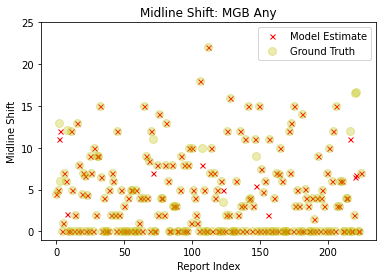

In [8]:
plot_rbs_scatter(mls_detected)

Text(0.5, 0, 'Report Index')

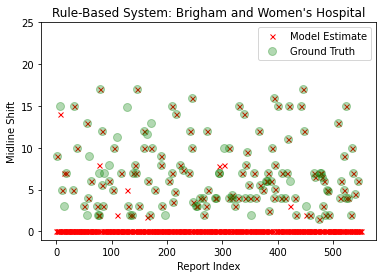

In [9]:
#Brigham
fig,ax = plt.subplots()
#complete_predictions = all_brigham.sample(frac=1).reset_index(drop=True)
df_for_plotting = mls_detected.sample(frac=0.25).reset_index(drop=True)
ax.plot(df_for_plotting['model_midline_shift'],'rx',label='Model Estimate',markersize=5)
ax.plot(df_for_plotting['MLS_mm'],'go',alpha=0.3,label='Ground Truth',markersize=8)
plt.title("Rule-Based System: Brigham and Women's Hospital")
plt.legend(loc='upper right')
plt.ylim(-1,25)
plt.ylabel('Midline Shift')
plt.xlabel('Report Index')
#plt.savefig('brigham_rbs.png')

In [7]:
mls_detected.columns

Index(['Age', 'EMPI', 'MLS_mm', 'Report_ID', 'Report_Text',
       'Report_Text_clean', 'Sex', 'Unnamed: 0', 'ecass_v2', 'edema_report',
       'edema_report_reasons___4', 'edema_severity_report', 'hem_conv_v2',
       'ivh_v2', 'model_midline_shift', 'no_mls', 'now_measuring', 'ptid',
       'report_description', 'rules_satisfied', 'shift_1', 'shift_2',
       'to_from'],
      dtype='object')

## Bootstrap MLS for MGB Large

In [6]:
np.random.seed(100)
bmc_mae=[]
bmc_accuracies=[]
bmc_sensitivities=[]
bmc_specificities=[]
bmc_ppvs=[]
bmc_npvs=[]


for i in range(100):
    bootstrapped=mls_detected.sample(n=100, replace=False)
    mae,accuracy,sensitivity,specificity,ppv,npv=compute_MLS_stats(bootstrapped)
    
    bmc_mae.append(mae)
    bmc_accuracies.append(accuracy)
    bmc_sensitivities.append(sensitivity)
    bmc_specificities.append(specificity)
    bmc_ppvs.append(ppv)
    bmc_npvs.append(npv)

NameError: name 'mls_detected' is not defined

In [ ]:
import scipy.stats as st
ci95_mae=st.t.interval(alpha=0.95, df=len(bmc_mae)-1, loc=np.mean(bmc_mae), scale=st.sem(bmc_mae))
ci95_sen=st.t.interval(alpha=0.95, df=len(bmc_sensitivities)-1, loc=np.mean(bmc_sensitivities), scale=st.sem(bmc_sensitivities))
ci95_spec=st.t.interval(alpha=0.95, df=len(bmc_specificities)-1, loc=np.mean(bmc_specificities), scale=st.sem(bmc_specificities))
ci95_acc=st.t.interval(alpha=0.95, df=len(bmc_accuracies)-1, loc=np.mean(bmc_accuracies), scale=st.sem(bmc_accuracies))
ci95_ppv=st.t.interval(alpha=0.95, df=len(bmc_ppvs)-1, loc=np.mean(bmc_ppvs), scale=st.sem(bmc_ppvs))

mean_mae=np.mean(bmc_mae)
mean_sen=np.mean(bmc_sensitivities)
mean_spec=np.mean(bmc_specificities)
mean_acc=np.mean(bmc_accuracies)
mean_ppv=np.mean(bmc_ppvs)

print('MAE, mean:{}, CI {}'.format(mean_mae,ci95_mae))
print('Sensitivity, mean: {}, CI: {}'.format(mean_sen,ci95_sen))
print('Specificity, mean: {}, CI: {}'.format(mean_sen,ci95_spec))
print('Accuracy, mean: {}, CI: {}'.format(mean_spec,ci95_acc))
print('Precision, mean: {}, CI: {}'.format(mean_ppv,ci95_ppv))

## I.III Now demonstration of the compute_MLS_stats() function:

In [4]:
def compute_MLS_stats(df,col_name='model_midline_shift'):
    """Computes overall accuracy, mean absolute error,sensitivity, specificity, PPV, and NPV from full dataset of 
    predictions and ground truth MLS measurements. 
    
    :param df - dataframe including a column of model predictions ("model_midline_shift") and ground
    truths ("MLS_mm")"""
    
    
    #oftentimes, MLS is left out as a NaN variable...
    df['MLS_mm']=df['MLS_mm'].fillna(0)
    
    #compute absolute difference
    df['abs_diff']=np.abs(df[col_name]-df['MLS_mm'])
    
    #mean absolute error
    mae=np.sum(df['abs_diff'])/len(df)
    
    #overall_accuracy
    accurate_hits = []
    for i,row in df.iterrows():
        if row['abs_diff']==0:
            accurate_hits.append(1)
        else:
            accurate_hits.append(0)
    accuracy=sum(accurate_hits)/len(accurate_hits)
    
    ##Sensitivity, Specificity, PPV, and NPV:
    
    #True positives
    tp_df = df[np.logical_and(df['abs_diff']==0,df['MLS_mm']!=0)]

    #True negatives
    tn_df = df[np.logical_and(df['abs_diff']==0,df['MLS_mm']==0)]
    
    #False Negatives:
    #constructing false positives and false negatives: start with your errors
    errors = df[df['abs_diff']!=0]
    fn_df = errors[np.logical_and(errors[col_name]==0,errors['MLS_mm']!=0)]
    
    #False positives: 2 ways: 1) Ground truth is zero and Model is nonzero 2) Ground truth is nonzero, Model is wrong nonzero
    cond_1 = errors[np.logical_and(errors[col_name]!=0,errors['MLS_mm']==0)]
    cond_2 = errors[np.logical_and(errors[col_name]!=0,errors['MLS_mm']!=0)]

    fp_df = pd.concat([cond_1,cond_2],axis=0)


    
    ##COMPUTE NUMBER OF TRUE NEGATIVES, TRUE POSITIVES, AND FALSE NEGATIVES:
    tp = len(tp_df)
    tn = len(tn_df)
    fn= len(fn_df)
    fp = len(fp_df)
    
    sensitivity=tp/(tp+fn+0.000001) 
    specificity=tn/(tn+fp+0.000001)
    ppv = tp/(tp+fp+0.00001)
    npv = tn/(tn+fn+0.00001)
    
    return mae,accuracy,sensitivity,specificity,ppv,npv

In [16]:
#MAE, accuracy, sensitivity, specificity, PPV, and NPV (in that order, as in the above definition)
compute_MLS_stats(mls_detected)

(0.17000907441016336,
 0.9677858439201452,
 0.9485815586018057,
 0.9743902433082986,
 0.927209689303125,
 0.9821757776141624)

In [34]:
BMC=pd.read_csv('OCTOBER8_377_BMC_ACUTE_STROKE_CONFIRMED.csv')
BMC=BMC.rename(columns={'midline_shift_mm':'MLS_mm'})
BMC=BMC[BMC['MLS_mm']!=999]
###this is for BMC:
BMC_mls_detected=detect_MLS(BMC)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

In [42]:
def plot_rbs_scatter(df):
    zero_df=df[df['model_midline_shift']==0].sample(frac=0.25).fillna(0)
    nonzero_df=df[df['model_midline_shift']!=0].sample(frac=1)
    
    #put dataframe back together
    df_for_plotting=pd.concat([zero_df,nonzero_df])
    df_for_plotting=df_for_plotting.sample(frac=1, axis=1).sample(frac=1).reset_index(drop=True)
    
    fig,ax=plt.subplots()
    
    ax.plot(df_for_plotting['model_midline_shift'],'rx',label='Model Estimate',markersize=5)
    ax.plot(df_for_plotting['MLS_mm'],'co',alpha=0.3,label='Ground Truth',markersize=8)
    plt.title("Midline Shift: BMC")
    plt.legend(loc='upper right')
    plt.ylim(-1,25)
    plt.ylabel('Midline Shift')
    plt.xlabel('Report Index')
    
    
    

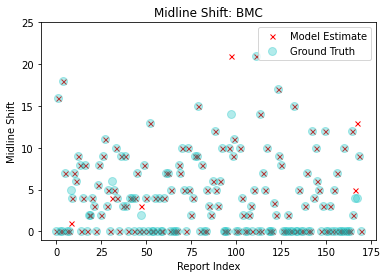

In [43]:
plot_rbs_scatter(BMC_mls_detected)

### Bootstrap BMC MLS Values:

In [10]:
np.random.seed(100)
bmc_mae=[]
bmc_accuracies=[]
bmc_sensitivities=[]
bmc_specificities=[]
bmc_ppvs=[]
bmc_npvs=[]


for i in range(100):
    bootstrapped=BMC_mls_detected.sample(n=100, replace=False)
    mae,accuracy,sensitivity,specificity,ppv,npv=compute_MLS_stats(bootstrapped)
    
    bmc_mae.append(mae)
    bmc_accuracies.append(accuracy)
    bmc_sensitivities.append(sensitivity)
    bmc_specificities.append(specificity)
    bmc_ppvs.append(ppv)
    bmc_npvs.append(npv)

In [30]:
compute_MLS_stats(BMC_mls_detected)

(0.14600550964187328,
 0.9696969696969697,
 0.9523809433106577,
 0.9767441822606815,
 0.9433961374154587,
 0.9805447089282215)

### Bootstrap:

In [14]:
import scipy.stats as st
ci95_mae=st.t.interval(alpha=0.95, df=len(bmc_mae)-1, loc=np.mean(bmc_mae), scale=st.sem(bmc_mae))
ci95_sen=st.t.interval(alpha=0.95, df=len(bmc_sensitivities)-1, loc=np.mean(bmc_sensitivities), scale=st.sem(bmc_sensitivities))
ci95_spec=st.t.interval(alpha=0.95, df=len(bmc_specificities)-1, loc=np.mean(bmc_specificities), scale=st.sem(bmc_specificities))
ci95_acc=st.t.interval(alpha=0.95, df=len(bmc_accuracies)-1, loc=np.mean(bmc_accuracies), scale=st.sem(bmc_accuracies))
ci95_ppv=st.t.interval(alpha=0.95, df=len(bmc_ppvs)-1, loc=np.mean(bmc_ppvs), scale=st.sem(bmc_ppvs))

mean_mae=np.mean(bmc_mae)
mean_sen=np.mean(bmc_sensitivities)
mean_spec=np.mean(bmc_specificities)
mean_acc=np.mean(bmc_accuracies)
mean_ppv=np.mean(bmc_ppvs)

print('MAE, mean:{}, CI {}'.format(mean_mae,ci95_mae))
print('Sensitivity, mean: {}, CI: {}'.format(mean_sen,ci95_sen))
print('Specificity, mean: {}, CI: {}'.format(mean_sen,ci95_spec))
print('Accuracy, mean: {}, CI: {}'.format(mean_spec,ci95_acc))
print('Precision, mean: {}, CI: {}'.format(mean_ppv,ci95_ppv))

MAE, mean:0.1416, CI (0.12461585966040906, 0.15858414033959095)
Sensitivity, mean: 0.9552810089423899, CI: (0.9484340064712607, 0.962128011413519)
Specificity, mean: 0.9552810089423899, CI: (0.973971588717241, 0.9801008149467308)
Accuracy, mean: 0.9770362018319859, CI: (0.9677276172016289, 0.9738723827983711)
Precision, mean: 0.9467420217745414, CI: (0.9399755408219859, 0.9535085027270969)


In [27]:
BMC_mls_detected['abs_diff']=np.abs(BMC_mls_detected['model_midline_shift']-BMC_mls_detected['MLS_mm'])

In [28]:
BMC_mls_detected['abs_diff'].value_counts()

0.0      352
999.0     14
1.0        2
5.0        2
9.0        2
7.0        2
2.0        1
4.0        1
3.0        1
Name: abs_diff, dtype: int64

In [9]:
batch1.columns

Index(['Unnamed: 0', 'Location_Report_ID', 'Report_Number',
       'Report_Description', 'Report_Date_Time', 'Report_Text', 'acute',
       'Acute Location Rev1', 'Need Review?', 'Unprocessed_Report_Text',
       'EMPI', 'edema_report', 'mls_mm_v2', 'hem_conv_v2', 'ecass_v2',
       'ivh_v2', 'Age', 'Sex', 'Gender'],
      dtype='object')

In [10]:
batch2.columns

Index(['Unnamed: 0', 'Location_Report_ID', 'Report_Number',
       'Report_Description', 'Report_Date_Time', 'Report_Text', 'acute',
       'Acute Location Rev1', 'Need Review?', 'Unprocessed_Report_Text',
       'EMPI', 'edema_report', 'mls_mm_v2', 'hem_conv_v2', 'ecass_v2',
       'ivh_v2', 'Age', 'Sex', 'Gender'],
      dtype='object')

#### Lastly: run MLS RBS on the non-Large stroke data

In [9]:
batch1=pd.read_csv('OCTOBER15_BWH_NONLARGE_BATCH1.csv')
batch2=pd.read_csv('OCTOBER15_BWH_NONLARGE_BATCH1.csv')

In [21]:
batch1=batch1[['Unprocessed_Report_Text','mls_mm_v2','Report_Number']]
batch2=batch2[['Unprocessed_Report_Text','mls_mm_v2','Report_Number']]
together=pd.concat([batch1,batch2])
together=together.rename(columns={'Unprocessed_Report_Text':'Report_Text','mls_mm_v2':'MLS_mm','Report_Number':'Report_ID'})

In [22]:
mls_detected=detect_MLS(together)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

In [23]:
compute_MLS_stats(mls_detected)

(0.03278688524590164,
 0.9890710382513661,
 0.9499999525000024,
 0.9938650245775152,
 0.9499995250002375,
 0.9938649697015356)

In [24]:
np.random.seed(100)
NL_mae=[]
NL_accuracies=[]
NL_sensitivities=[]
NL_specificities=[]
NL_ppvs=[]
NL_npvs=[]


for i in range(100):
    bootstrapped=mls_detected.sample(n=100, replace=False)
    mae,accuracy,sensitivity,specificity,ppv,npv=compute_MLS_stats(bootstrapped)
    
    NL_mae.append(mae)
    NL_accuracies.append(accuracy)
    NL_sensitivities.append(sensitivity)
    NL_specificities.append(specificity)
    NL_ppvs.append(ppv)
    NL_npvs.append(npv)

In [25]:
import scipy.stats as st
ci95_mae=st.t.interval(alpha=0.95, df=len(NL_mae)-1, loc=np.mean(NL_mae), scale=st.sem(NL_mae))
ci95_sen=st.t.interval(alpha=0.95, df=len(NL_sensitivities)-1, loc=np.mean(NL_sensitivities), scale=st.sem(NL_sensitivities))
ci95_spec=st.t.interval(alpha=0.95, df=len(NL_specificities)-1, loc=np.mean(NL_specificities), scale=st.sem(NL_specificities))
ci95_acc=st.t.interval(alpha=0.95, df=len(NL_accuracies)-1, loc=np.mean(NL_accuracies), scale=st.sem(NL_accuracies))
ci95_ppv=st.t.interval(alpha=0.95, df=len(NL_ppvs)-1, loc=np.mean(NL_ppvs), scale=st.sem(NL_ppvs))

mean_mae=np.mean(NL_mae)
mean_sen=np.mean(NL_sensitivities)
mean_spec=np.mean(NL_specificities)
mean_acc=np.mean(NL_accuracies)
mean_ppv=np.mean(NL_ppvs)

print('MAE, mean:{}, CI {}'.format(mean_mae,ci95_mae))
print('Sensitivity, mean: {}, CI: {}'.format(mean_sen,ci95_sen))
print('Specificity, mean: {}, CI: {}'.format(mean_sen,ci95_spec))
print('Accuracy, mean: {}, CI: {}'.format(mean_spec,ci95_acc))
print('Precision, mean: {}, CI: {}'.format(mean_ppv,ci95_ppv))

MAE, mean:0.03440000000000001, CI (0.029991751524879103, 0.03880824847512091)
Sensitivity, mean: 0.9484995319523745, CI: (0.9390797809195204, 0.9579192829852285)
Specificity, mean: 0.9484995319523745, CI: (0.9923679898021192, 0.9945836913588002)
Accuracy, mean: 0.9934758405804597, CI: (0.9871076164996435, 0.9898923835003564)
Precision, mean: 0.947506018665008, CI: (0.9380782851498067, 0.9569337521802094)


# Part II: RBS for IVH

Hi Ben. I hope that the above worked for you. What follows below is my rule-based system for IVH. The preprocessing clean_and_featurize() function should be similar, but time time I don't do additional preprocessing to remove numbers! Instead, I preprocess to remove likely confounding words, a list of which may be found in one of the cells below. 

It is very important that your IVH column be in a format where 1=IVH and 0=no IVH. I've noticed that Charlene sometimes has additional measures for "scant IVH, moderate IVH, etc". This one 

In [8]:
df = pd.read_csv('LargeMGB_IVH_for_RBS.csv')
df.rename(columns={'report_text': 'Report_Text', 'mls_mm_v2': 'MLS_mm','Report_Number':'Report_ID','ecass_v2':'ECASS','edema_severity_report':'edema_severity'}, inplace=True)
wordgroups = list(pd.read_excel('wordgroups.xlsx')['Word Groupings'])#now clean and featurize
df_overall = clean_and_featurize(df,wordgroups)


In [9]:
confounders=['masseffect','mass-effect','effacement','compression','periventricular',
            'subarachnoidhemorrhage','ventriculostomy','intraparenchymalhemorrhage',
             ',','subdural','no significant','nonhemorrhag','intracerebralhemorrhage','petechialhemorrhage',
            'or intraventricular','adjacent to','inferior to','superior to','infarct','conversion','normal',
            'ventriculoperitoneal']

transformed_reports=[]

for _,row in df_overall.iterrows():
    
    #get the report
    original_report=row['Report_Text_clean']
    
    
    
    #test out each of the confounders
    for i in confounders:
        original_report=original_report.replace(i,'.')

            
    transformed_reports.append(original_report)
    
df_overall['periods_add']=transformed_reports

#now remove the term 'subarachnoid' as well:
subarachnoid_removed=[]

for row in transformed_reports:
    new_row=row.replace('subarachnoid','____')
    subarachnoid_removed.append(new_row)
    
df_overall['periods_add']=subarachnoid_removed

## II.I: Define your Rules

In [10]:
ivh_direct_mention=re.compile(r'intraventricularh|interventricular h')
in_ventricles=re.compile(r'blood.+in.+?ventri|hemorr.+in.+?ventri|hemorr.+?ventri|ventri.+?blood|ventri.+?hemorr|ventri.+?extension')
in_horn=re.compile(r'blood.+in.+?horn|hemorr.+in.+?horn|horn.+?blood|horn.+?hemorr')
rupture=re.compile(r'rupture.+?vent')

#negative rules:
#antimention=re.compile(r'no.+extra-axial hem|no.+extraaxial hem|no.+?intraventricularhemorrhage|no.+?interventricular hemorrhage|no.+?intra ventricular hemorrhage|no.+blood.+ventri|no.+ventric.+?extens')
antimention=re.compile(r'no.+extra-axial hem|no.+extraaxial hem|no.+?intraventricularhemorrhage|no.+?interventricular hemorrhage|no.+?intra ventricular hemorrhage|no.+ventric.+?extens|without.+?intraventricularhemorrhage')

### Now apply the rules above

In [23]:
ground_truth=[]
prediction=[]

for i,row in df_overall.iterrows():
    doc=[]
    ground_truth.append(row['IVH'])
    for sentence in row['periods_add'].split('.'):
        if len(in_ventricles.findall(sentence))>0:
            doc.append(1)
        
        elif len(ivh_direct_mention.findall(sentence))>0:   
            doc.append(1)
        elif len(in_horn.findall(sentence))>0:   
            doc.append(1)
            
        elif len(rupture.findall(sentence))>0:   
            doc.append(1)
            
        else:
            pass
            
    for sentence in row['periods_add'].split('.'):
        if len(antimention.findall(sentence))>0:
            doc=[]
            
        
    if len(doc)>0:
        prediction.append(1)
    else:
        prediction.append(0)
        

## An integrated RBS for IVH:

In [11]:
def integrated_ivh(df_overall,text_column='Report_Text_clean'):
    
    ivh_direct_mention=re.compile(r'intraventricularh|interventricular h')
    in_ventricles=re.compile(r'blood.+in.+?ventri|hemorr.+in.+?ventri|hemorr.+?ventri|ventri.+?blood|ventri.+?hemorr|ventri.+?extension')
    in_horn=re.compile(r'blood.+in.+?horn|hemorr.+in.+?horn|horn.+?blood|horn.+?hemorr')
    rupture=re.compile(r'rupture.+?vent')

    #negative rules:
    #antimention=re.compile(r'no.+extra-axial hem|no.+extraaxial hem|no.+?intraventricularhemorrhage|no.+?interventricular hemorrhage|no.+?intra ventricular hemorrhage|no.+blood.+ventri|no.+ventric.+?extens')
    antimention=re.compile(r'no.+extra-axial hem|no.+extraaxial hem|no.+?intraventricularhemorrhage|no.+?interventricular hemorrhage|no.+?intra ventricular hemorrhage|no.+ventric.+?extens|without.+?intraventricularhemorrhage')

    confounders=['masseffect','mass-effect','effacement','compression','periventricular',
                'subarachnoidhemorrhage','ventriculostomy','intraparenchymalhemorrhage',
                 ',','subdural','no significant','nonhemorrhag','intracerebralhemorrhage','petechialhemorrhage',
                'or intraventricular','adjacent to','inferior to','superior to','infarct','conversion','normal',
                'ventriculoperitoneal']

    transformed_reports=[]

    for _,row in df_overall.iterrows():

        #get the report
        original_report=row[text_column]



        #test out each of the confounders
        for i in confounders:
            original_report=original_report.replace(i,'.')


        transformed_reports.append(original_report)

    df_overall['periods_add']=transformed_reports

    #now remove the term 'subarachnoid' as well:
    subarachnoid_removed=[]

    for row in transformed_reports:
        new_row=row.replace('subarachnoid','____')
        subarachnoid_removed.append(new_row)

    df_overall['periods_add']=subarachnoid_removed


    ground_truth=[]
    prediction=[]

    for i,row in df_overall.iterrows():
        doc=[]
        ground_truth.append(row['IVH'])
        for sentence in row['periods_add'].split('.'):
            if len(in_ventricles.findall(sentence))>0:
                doc.append(1)

            elif len(ivh_direct_mention.findall(sentence))>0:   
                doc.append(1)
            elif len(in_horn.findall(sentence))>0:   
                doc.append(1)

            elif len(rupture.findall(sentence))>0:   
                doc.append(1)

            else:
                pass

        for sentence in row['periods_add'].split('.'):
            if len(antimention.findall(sentence))>0:
                doc=[]


        if len(doc)>0:
            prediction.append(1)
        else:
            prediction.append(0)
        
    return ground_truth,prediction

In [12]:
t0=time.time()

g,p=integrated_ivh(df_overall)
t1=time.time()
total=t1-t0
print(total)

tn, fp, fn, tp = confusion_matrix(g,p).ravel()
sensitivity=tn/(tn+fp)
precision=tp/(tp+fp)
print('sensitivity {}'.format(sensitivity))
print('precision {}'.format(precision))

1.024226188659668
sensitivity 0.9918815663801337
precision 0.8521739130434782


### Assess the success of your rules above:

In [24]:
df_overall['ground_truth']=ground_truth
df_overall['prediction']=prediction
tn, fp, fn, tp = confusion_matrix(ground_truth, prediction).ravel()
sensitivity=tn/(tn+fp)
precision=tp/(tp+fp)
print('sensitivity {}'.format(sensitivity))
print('precision {}'.format(precision))

sensitivity 0.9918815663801337
precision 0.8521739130434782


### Bootstrap IVH stats

In [28]:
df_overall.shape

(2199, 16)

In [37]:
np.random.seed(100)
bmc_accuracies=[]
bmc_sensitivities=[]
bmc_specificities=[]
bmc_ppvs=[]



for i in range(100):
    bootstrapped=df_overall.sample(n=200, replace=False)

    ground=bootstrapped['ground_truth']
    pred=bootstrapped['prediction']
    tn, fp, fn, tp = confusion_matrix(ground, pred).ravel()
    
    
    accuracy=(tn+tp)/(tn+tp+fn+fp)
    sensitivity=tp/(tp+fn)
    specificity=tn/(tn+fp)
    ppv=tp/(tp+fp)
    
    
    bmc_accuracies.append(accuracy)
    bmc_sensitivities.append(sensitivity)
    bmc_specificities.append(specificity)
    bmc_ppvs.append(ppv)

    
import scipy.stats as st
ci95_sen=st.t.interval(alpha=0.95, df=len(bmc_sensitivities)-1, loc=np.mean(bmc_sensitivities), scale=st.sem(bmc_sensitivities))
ci95_spec=st.t.interval(alpha=0.95, df=len(bmc_specificities)-1, loc=np.mean(bmc_specificities), scale=st.sem(bmc_specificities))
ci95_acc=st.t.interval(alpha=0.95, df=len(bmc_accuracies)-1, loc=np.mean(bmc_accuracies), scale=st.sem(bmc_accuracies))
ci95_ppv=st.t.interval(alpha=0.95, df=len(bmc_ppvs)-1, loc=np.mean(bmc_ppvs), scale=st.sem(bmc_ppvs))


mean_sen=np.mean(bmc_sensitivities)
mean_spec=np.median(bmc_specificities)
mean_acc=np.mean(bmc_accuracies)
mean_ppv=np.mean(bmc_ppvs)

print('MAE, mean:{}, CI {}'.format(mean_mae,ci95_mae))
print('Sensitivity, mean: {}, CI: {}'.format(mean_sen,ci95_sen))
print('Specificity, mean: {}, CI: {}'.format(mean_sen,ci95_spec))
print('Accuracy, mean: {}, CI: {}'.format(mean_spec,ci95_acc))
print('Precision, mean: {}, CI: {}'.format(mean_ppv,ci95_ppv))

### Now do this for BMC:

In [40]:
df = pd.read_csv('OCTOBER8_377_BMC_ACUTE_STROKE_CONFIRMED.csv')
df.rename(columns={'ivh':'IVH','Report_Number':'Report_ID'}, inplace=True)
wordgroups = list(pd.read_excel('wordgroups.xlsx')['Word Groupings'])#now clean and featurize
df_overall = clean_and_featurize(df,wordgroups)
df_overall=df_overall[np.logical_or(df_overall['IVH']==0,df_overall['IVH']==1)]

In [41]:
confounders=['masseffect','mass-effect','effacement','compression','periventricular',
            'subarachnoidhemorrhage','ventriculostomy','intraparenchymalhemorrhage',
             ',','subdural','no significant','nonhemorrhag','intracerebralhemorrhage','petechialhemorrhage',
            'or intraventricular','adjacent to','inferior to','superior to','infarct','conversion','normal',
            'ventriculoperitoneal']

transformed_reports=[]

for _,row in df_overall.iterrows():
    
    #get the report
    original_report=row['Report_Text_clean']
    
    
    
    #test out each of the confounders
    for i in confounders:
        original_report=original_report.replace(i,'.')

            
    transformed_reports.append(original_report)
    
df_overall['periods_add']=transformed_reports

#now remove the term 'subarachnoid' as well:
subarachnoid_removed=[]

for row in transformed_reports:
    new_row=row.replace('subarachnoid','____')
    subarachnoid_removed.append(new_row)
    
df_overall['periods_add']=subarachnoid_removed

In [42]:
ground_truth=[]
prediction=[]

for i,row in df_overall.iterrows():
    doc=[]
    ground_truth.append(row['IVH'])
    for sentence in row['periods_add'].split('.'):
        if len(in_ventricles.findall(sentence))>0:
            doc.append(1)
        
        elif len(ivh_direct_mention.findall(sentence))>0:   
            doc.append(1)
        elif len(in_horn.findall(sentence))>0:   
            doc.append(1)
            
        elif len(rupture.findall(sentence))>0:   
            doc.append(1)
            
        else:
            pass
            
    for sentence in row['periods_add'].split('.'):
        if len(antimention.findall(sentence))>0:
            doc=[]
            
        
    if len(doc)>0:
        prediction.append(1)
    else:
        prediction.append(0)
        

In [43]:
df_overall['ground_truth']=ground_truth
df_overall['prediction']=prediction
tn, fp, fn, tp = confusion_matrix(ground_truth, prediction).ravel()
sensitivity=tn/(tn+fp)
precision=(tp+tn)/(tp+fp+tn+fn)
print('sensitivity {}'.format(sensitivity))
print('precision {}'.format(precision))

sensitivity 0.9943820224719101
precision 0.9918478260869565


In [44]:
np.random.seed(100)
bmc_accuracies=[]
bmc_sensitivities=[]
bmc_specificities=[]
bmc_ppvs=[]



for i in range(100):
    bootstrapped=df_overall.sample(n=200, replace=False)

    ground=bootstrapped['ground_truth']
    pred=bootstrapped['prediction']
    tn, fp, fn, tp = confusion_matrix(ground, pred).ravel()
    
    
    accuracy=(tn+tp)/(tn+tp+fn+fp)
    sensitivity=tp/(tp+fn)
    specificity=tn/(tn+fp)
    ppv=tp/(tp+fp)
    
    
    bmc_accuracies.append(accuracy)
    bmc_sensitivities.append(sensitivity)
    bmc_specificities.append(specificity)
    bmc_ppvs.append(ppv)

    
import scipy.stats as st
ci95_sen=st.t.interval(alpha=0.95, df=len(bmc_sensitivities)-1, loc=np.mean(bmc_sensitivities), scale=st.sem(bmc_sensitivities))
ci95_spec=st.t.interval(alpha=0.95, df=len(bmc_specificities)-1, loc=np.mean(bmc_specificities), scale=st.sem(bmc_specificities))
ci95_acc=st.t.interval(alpha=0.95, df=len(bmc_accuracies)-1, loc=np.mean(bmc_accuracies), scale=st.sem(bmc_accuracies))
ci95_ppv=st.t.interval(alpha=0.95, df=len(bmc_ppvs)-1, loc=np.mean(bmc_ppvs), scale=st.sem(bmc_ppvs))


mean_sen=np.mean(bmc_sensitivities)
mean_spec=np.median(bmc_specificities)
mean_acc=np.mean(bmc_accuracies)
mean_ppv=np.mean(bmc_ppvs)

print('MAE, mean:{}, CI {}'.format(mean_mae,ci95_mae))
print('Sensitivity, mean: {}, CI: {}'.format(mean_sen,ci95_sen))
print('Specificity, mean: {}, CI: {}'.format(mean_sen,ci95_spec))
print('Accuracy, mean: {}, CI: {}'.format(mean_spec,ci95_acc))
print('Precision, mean: {}, CI: {}'.format(mean_ppv,ci95_ppv))

MAE, mean:0.18038000000000007, CI (0.15913254587757814, 0.201627454122422)
Sensitivity, mean: 0.9086150793650793, CI: (0.8899606143626602, 0.9272695443674985)
Specificity, mean: 0.9086150793650793, CI: (0.9931488409957041, 0.994671124044664)
Accuracy, mean: 0.9947916666666666, CI: (0.9903764641067478, 0.9921235358932521)
Precision, mean: 0.825196248196248, CI: (0.8007372413070171, 0.849655255085479)


### Lastly: Do this for MGB non-Large

In [80]:
batch1=pd.read_csv('OCTOBER15_BWH_NONLARGE_BATCH1.csv')
batch2=pd.read_csv('OCTOBER15_BWH_NONLARGE_BATCH2.csv')
together=pd.concat([batch1,batch2])
together=together[['Location_Report_ID','Unprocessed_Report_Text','ivh_v2']]
together=together.rename(columns={'Location_Report_ID':'Report_ID','Unprocessed_Report_Text':'Report_Text',
                                 'ivh_v2':'IVH'})

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
together['IVH']=together['IVH'].fillna(1.0)
together['IVH'].value_counts(dropna=False)
together['IVH']=together['IVH'].apply(lambda x:0 if x==1 else 1)
together['IVH'].value_counts(dropna=False)

0    502
1     18
Name: IVH, dtype: int64

In [82]:
df_overall = clean_and_featurize(together,wordgroups)
#df_overall=df_overall[np.logical_or(df_overall['IVH']==0,df_overall['IVH']==1)]

In [83]:
confounders=['masseffect','mass-effect','effacement','compression','periventricular',
            'subarachnoidhemorrhage','ventriculostomy','intraparenchymalhemorrhage',
             ',','subdural','no significant','nonhemorrhag','intracerebralhemorrhage','petechialhemorrhage',
            'or intraventricular','adjacent to','inferior to','superior to','infarct','conversion','normal',
            'ventriculoperitoneal']

transformed_reports=[]

for _,row in df_overall.iterrows():
    
    #get the report
    original_report=row['Report_Text_clean']
    
    
    
    #test out each of the confounders
    for i in confounders:
        original_report=original_report.replace(i,'.')

            
    transformed_reports.append(original_report)
    
df_overall['periods_add']=transformed_reports

#now remove the term 'subarachnoid' as well:
subarachnoid_removed=[]

for row in transformed_reports:
    new_row=row.replace('subarachnoid','____')
    subarachnoid_removed.append(new_row)
    
df_overall['periods_add']=subarachnoid_removed

In [84]:
ground_truth=[]
prediction=[]

for i,row in df_overall.iterrows():
    doc=[]
    ground_truth.append(row['IVH'])
    for sentence in row['periods_add'].split('.'):
        if len(in_ventricles.findall(sentence))>0:
            doc.append(1)
        
        elif len(ivh_direct_mention.findall(sentence))>0:   
            doc.append(1)
        elif len(in_horn.findall(sentence))>0:   
            doc.append(1)
            
        elif len(rupture.findall(sentence))>0:   
            doc.append(1)
            
        else:
            pass
            
    for sentence in row['periods_add'].split('.'):
        if len(antimention.findall(sentence))>0:
            doc=[]
            
        
    if len(doc)>0:
        prediction.append(1)
    else:
        prediction.append(0)
        

In [85]:
df_overall['ground_truth']=ground_truth
df_overall['prediction']=prediction
tn, fp, fn, tp = confusion_matrix(ground_truth, prediction).ravel()
sensitivity=tp/(tp+fn)
precision=(tp)/(tp+fp)
print('sensitivity {}'.format(sensitivity))
print('precision {}'.format(precision))

sensitivity 0.9444444444444444
precision 0.85


In [89]:
np.random.seed(100)
bmc_accuracies=[]
bmc_sensitivities=[]
bmc_specificities=[]
bmc_ppvs=[]



for i in range(100):
    bootstrapped=df_overall.sample(n=200, replace=False)

    ground=bootstrapped['ground_truth']
    pred=bootstrapped['prediction']
    tn, fp, fn, tp = confusion_matrix(ground, pred).ravel()
    
    
    accuracy=(tn+tp)/(tn+tp+fn+fp)
    sensitivity=tp/(tp+fn)
    specificity=tn/(tn+fp)
    ppv=tp/(tp+fp)
    
    
    bmc_accuracies.append(accuracy)
    bmc_sensitivities.append(sensitivity)
    bmc_specificities.append(specificity)
    bmc_ppvs.append(ppv)

    
import scipy.stats as st
ci95_sen=st.t.interval(alpha=0.95, df=len(bmc_sensitivities)-1, loc=np.mean(bmc_sensitivities), scale=st.sem(bmc_sensitivities))
ci95_spec=st.t.interval(alpha=0.95, df=len(bmc_specificities)-1, loc=np.median(bmc_specificities), scale=st.sem(bmc_specificities))
ci95_acc=st.t.interval(alpha=0.95, df=len(bmc_accuracies)-1, loc=np.mean(bmc_accuracies), scale=st.sem(bmc_accuracies))
ci95_ppv=st.t.interval(alpha=0.95, df=len(bmc_ppvs)-1, loc=np.mean(bmc_ppvs), scale=st.sem(bmc_ppvs))


mean_sen=np.mean(bmc_sensitivities)
mean_spec=np.median(bmc_specificities)
mean_acc=np.mean(bmc_accuracies)
mean_ppv=np.mean(bmc_ppvs)

#print('MAE, mean:{}, CI {}'.format(mean_mae,ci95_mae))
print('Sensitivity, mean: {}, CI: {}'.format(mean_sen,ci95_sen))
print('Specificity, mean: {}, CI: {}'.format(mean_sen,ci95_spec))
print('Accuracy, mean: {}, CI: {}'.format(mean_spec,ci95_acc))
print('Precision, mean: {}, CI: {}'.format(mean_ppv,ci95_ppv))

Sensitivity, mean: 0.9392456709956711, CI: (0.9239622495110035, 0.9545290924803388)
Specificity, mean: 0.9392456709956711, CI: (0.9939987790250262, 0.9956385266744556)
Accuracy, mean: 0.9948186528497409, CI: (0.9912897185894054, 0.9932102814105943)
Precision, mean: 0.847641774891775, CI: (0.8262918971648882, 0.8689916526186617)


In [92]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [95]:
mean_confidence_interval(bmc_ppvs)

(0.847641774891775, 0.8262918971648882, 0.8689916526186617)